# Template Matching Chord Recognition, *Francesco Maccarini*

## Project for the *Audio Signals* course @ Polimi

In this notebook we aim at providing a python implementation of the chord recognition algorithm based on template matching, as presented in: "Müller, Meinard. (2015). *Fundamentals of Music Processing.* 10.1007/978-3-319-21945-5."

### Introduction

We start by constructing the templates for major and minor triads. In chroma representation, every chord is characterized by a 1 in correspndence to those notes that are present in the chord and a 0 in correspondence to those notes that are not present in the chord.

Remember that chroma values are mapped to notes as 
\[ C, C#, D, D#, E, F, F#, G, G#, A, A#, B \]

***

**Example:** C major chord is composed by the notes C, E and G so its chorma representation will be \[ 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0 \]

In [1]:
triads_labs=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B","Cm","C#m","Dm","D#m","Em","Fm","F#m","Gm","G#m","Am","A#m","Bm"]
chroma_labs=["C","C#","D","D#","E","F","F#","G","G#","A","A#","B"]
print("Labels for possible triads:")
print(triads_labs)
print("Major triads:")
print(triads_labs[0:12])
print("Minor triads:")
print(triads_labs[12:])
print("Chroma values (notes):")
print(chroma_labs)

Labels for possible triads:
['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B', 'Cm', 'C#m', 'Dm', 'D#m', 'Em', 'Fm', 'F#m', 'Gm', 'G#m', 'Am', 'A#m', 'Bm']
Major triads:
['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
Minor triads:
['Cm', 'C#m', 'Dm', 'D#m', 'Em', 'Fm', 'F#m', 'Gm', 'G#m', 'Am', 'A#m', 'Bm']
Chroma values (notes):
['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']


In [2]:
import numpy as np

In [3]:
#create chroma templates for chords
chords=np.zeros(shape=(12,len(triads_labs)))
for i in range(chords.shape[1]): #loop on possible triads
    if(i<12):
        chords[(0+i)%12,i]=1
        chords[(4+i)%12,i]=1
        chords[(7+i)%12,i]=1
    if(i>=12):
        chords[(0+i)%12,i]=1
        chords[(3+i)%12,i]=1
        chords[(7+i)%12,i]=1
#print(chords)

In [4]:
import matplotlib.pyplot as plt
import librosa.display as dspl

Text(0.5, 1.0, 'Chroma representation of major and minor triads')

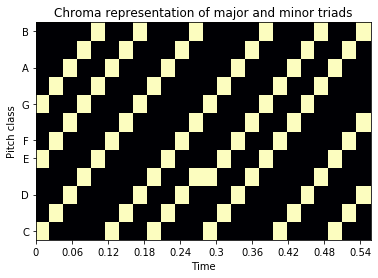

In [5]:
plt.figure()
dspl.specshow(chords, y_axis='chroma', x_axis='time')
plt.title("Chroma representation of major and minor triads")

### Load audio file

In [6]:
from tkinter import filedialog
from tkinter import *

from librosa import *

import ntpath

In [7]:
# Select the file to analyze
root = Tk()
root.filename =  filedialog.askopenfilename(initialdir = "/",title = "Select an audio file",filetypes = (("all files","*.*"),("jpeg files","*.jpg")))
if(root.filename):
    #print ("Selected file path:",root.filename)
    name=ntpath.basename(root.filename)
    print ("Selected file name:",name)
else:
    print ("Please select a file!")
root.destroy()

Selected file name: Major_minor_triads_piano.wav


In [12]:
# loading file with librosa
#music,sr=load(root.filename,duration=10.0)
music,sr=load(root.filename)

# WARNING: You need to have ffmpeg insalled in order to open mp3 files
# If you are using conda/anaconda runnig the following in the command prompt should fix the problem:
# conda install -c conda-forge ffmpeg

print("Sampling rate:",sr)

Sampling rate: 22050


In [13]:
import matplotlib.pyplot as plt
import librosa.display as dspl

Text(0.5, 1.0, 'Opened music file: Major_minor_triads_piano.wav')

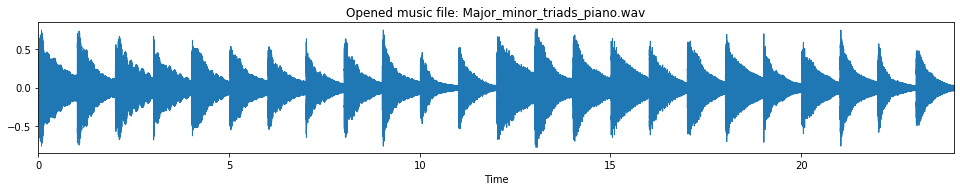

In [14]:
plt.figure(figsize=(16.4, 2.4))
dspl.waveplot(music,sr)
plt.title("Opened music file: "+name)

In [15]:
# Play oudio
import sounddevice as sd
sd.play(music, sr)

In [16]:
# Ok! Stop it!
sd.stop()

### Chromagram Computation

In [17]:
import librosa.feature as feat
#chroma=feat.chroma_cens(y=music,sr=sr,norm=1,hop_length=128,smoothing_window=41)
chroma=feat.chroma_stft(y=music,sr=sr,norm=1,hop_length=512,tuning=0,octwidth=None)
from librosa import mu_compress # this function is available only in recent versions of the package (for instance librosa 7.2)
chroma_compr = mu_compress(chroma, quantize=False, mu=50)

In [18]:
#print(chroma)
print(chroma.shape)

(12, 1034)


Text(0.5, 1.0, 'Compressed chroma representation of Major_minor_triads_piano.wav')

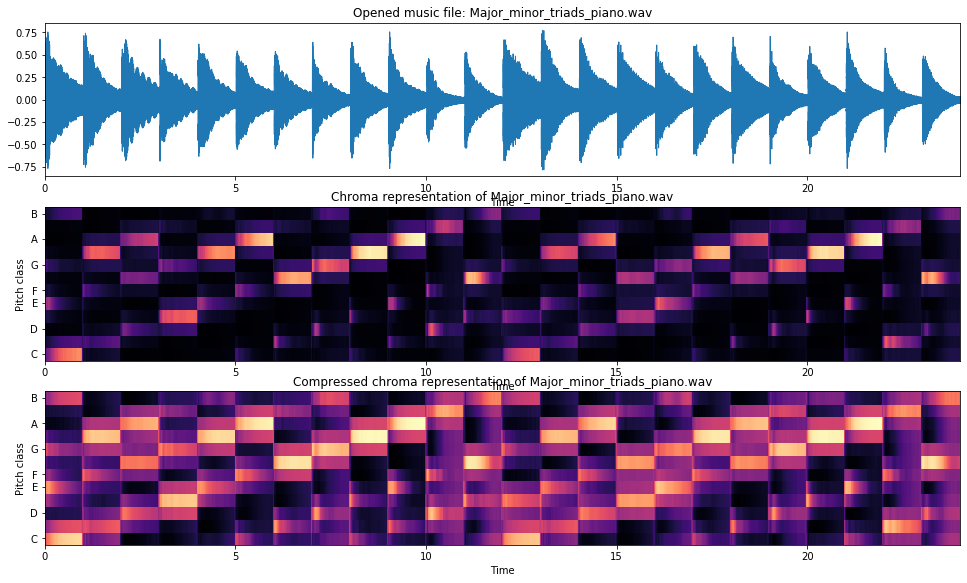

In [19]:
plt.figure(figsize=(16.4, 9.6))
plt.subplot(3,1,1)
dspl.waveplot(music,sr)
plt.title("Opened music file: "+name)
plt.subplot(3,1,2)
dspl.specshow(chroma, y_axis='chroma', x_axis='time')
plt.title("Chroma representation of "+name)
plt.subplot(3,1,3)
dspl.specshow(chroma_compr, y_axis='chroma', x_axis='time')
plt.title("Compressed chroma representation of "+name)

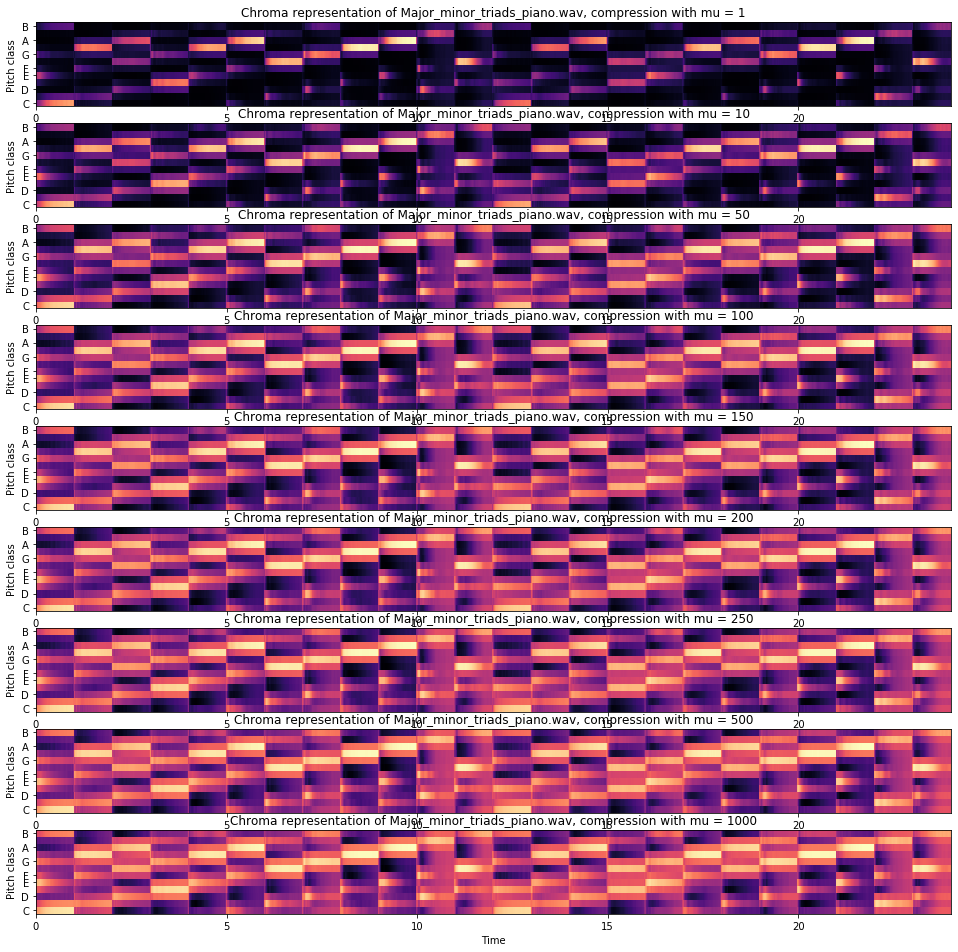

In [20]:
# The right parameter mu
plt.figure(figsize=(16.4, 16.4))
i=0
for mu in [1, 10, 50, 100, 150, 200, 250, 500, 1000]:
    i=i+1
    chroma_tmp = mu_compress(chroma,mu=mu, quantize=False)
    plt.subplot(9,1,i)
    dspl.specshow(chroma_tmp, y_axis='chroma', x_axis='time')
    plt.title("Chroma representation of "+name+", compression with mu = "+str(mu))

In [21]:
def template_matching(chroma,chords,chords_labs):
    nvals=chroma.shape[1]
    nchords=chords.shape[1]
    est_chords=np.zeros(shape=nvals,dtype=int)
    dist=np.zeros(shape=nchords)
    for i in range(nvals):
        for ch in range(nchords):
            dist[ch]=np.linalg.norm(chroma[:,i]-chords[:,ch])
            est_chords[i]=np.argmin(dist)
        print(str(i)+"\t"+str(est_chords[i])+"\t"+chords_labs[est_chords[i]])
    return est_chords
        
estimated=template_matching(chroma_compr,chords,chords_labs=triads_labs)

0	0	C
1	0	C
2	0	C
3	0	C
4	0	C
5	0	C
6	0	C
7	0	C
8	0	C
9	0	C
10	0	C
11	0	C
12	0	C
13	0	C
14	0	C
15	0	C
16	0	C
17	0	C
18	0	C
19	0	C
20	0	C
21	0	C
22	0	C
23	0	C
24	0	C
25	0	C
26	0	C
27	0	C
28	0	C
29	0	C
30	0	C
31	0	C
32	0	C
33	0	C
34	0	C
35	0	C
36	0	C
37	0	C
38	0	C
39	0	C
40	0	C
41	0	C
42	0	C
43	17	Fm
44	1	C#
45	1	C#
46	1	C#
47	1	C#
48	1	C#
49	1	C#
50	1	C#
51	1	C#
52	1	C#
53	1	C#
54	1	C#
55	1	C#
56	1	C#
57	1	C#
58	1	C#
59	1	C#
60	1	C#
61	1	C#
62	1	C#
63	1	C#
64	1	C#
65	1	C#
66	1	C#
67	1	C#
68	1	C#
69	1	C#
70	1	C#
71	1	C#
72	1	C#
73	1	C#
74	1	C#
75	1	C#
76	1	C#
77	1	C#
78	1	C#
79	1	C#
80	1	C#
81	1	C#
82	1	C#
83	1	C#
84	1	C#
85	1	C#
86	2	D
87	2	D
88	2	D
89	2	D
90	2	D
91	2	D
92	2	D
93	2	D
94	2	D
95	2	D
96	2	D
97	2	D
98	2	D
99	2	D
100	2	D
101	2	D
102	2	D
103	2	D
104	2	D
105	2	D
106	2	D
107	2	D
108	2	D
109	2	D
110	2	D
111	2	D
112	2	D
113	2	D
114	2	D
115	2	D
116	2	D
117	2	D
118	2	D
119	2	D
120	2	D
121	2	D
122	2	D
123	2	D
124	2	D
125	2	D
126	2	D
127	2	D
128	2	D
129	2	D
130	3	D#
131	3	D#
132	3	D#